In [115]:
import google.auth
from google.cloud import bigquery


credentials, project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

client = bigquery.Client(credentials=credentials, project=project_id,)


In [116]:
#create target variable if arrival_delay is more than 15 then marked as delayed
query="""
SELECT *, 
case
 when arrival_delay >= 15 then 1
 else 0
end as delayed
FROM `bigquery-samples.airline_ontime_data.flights` 
where 
MOD(ABS(FARM_FINGERPRINT(CAST(date AS STRING))), 500)= 1

"""
flights = client.query(query).to_dataframe()

num_of_rows = flights.shape[0]
print('rows:',num_of_rows)
flights.head(n=5)

rows: 107450


,date,airline,airline_code,departure_airport,departure_state,departure_lat,departure_lon,arrival_airport,arrival_state,arrival_lat,arrival_lon,departure_schedule,departure_actual,departure_delay,arrival_schedule,arrival_actual,arrival_delay,delayed
0,2003-06-06,DH,20404,IAD,VA,38.94,-77.46,LGA,NY,40.77,-73.87,1035,1115,40.0,1153,1220,27.0,1
1,2003-06-06,DH,20404,IAD,VA,38.94,-77.46,LGA,NY,40.77,-73.87,1245,1240,-5.0,1401,1338,-23.0,0
2,2003-06-06,DH,20404,IAD,VA,38.94,-77.46,LGA,NY,40.77,-73.87,1545,1610,25.0,1700,1713,13.0,0
3,2003-06-06,DH,20404,IAD,VA,38.94,-77.46,LGA,NY,40.77,-73.87,1715,1709,-6.0,1830,1824,-6.0,0
4,2003-06-06,DH,20404,IAD,VA,38.94,-77.46,LGA,NY,40.77,-73.87,2135,2134,-1.0,2245,2253,8.0,0


In [117]:
#flight id defined by route airport codes, schedule date time
flights['flight_id'] = flights.groupby(['date','airline_code', 'departure_airport', 'arrival_airport', 'departure_schedule','arrival_schedule']).ngroup()

In [118]:
avg_delay_query="""

SELECT 
  airline,
  departure_airport,
  AVG(departure_delay)
FROM `bigquery-samples.airline_ontime_data.flights`
GROUP BY 1, 2
"""
#average delay of flight

flights['avg_arrival_delay'] = flights.groupby(['flight_id'])['arrival_delay'].mean()
flights.head()

,date,airline,airline_code,departure_airport,departure_state,departure_lat,departure_lon,arrival_airport,arrival_state,arrival_lat,arrival_lon,departure_schedule,departure_actual,departure_delay,arrival_schedule,arrival_actual,arrival_delay,delayed,flight_id,avg_arrival_delay
0,2003-06-06,DH,20404,IAD,VA,38.94,-77.46,LGA,NY,40.77,-73.87,1035,1115,40.0,1153,1220,27.0,1,17110,-13.0
1,2003-06-06,DH,20404,IAD,VA,38.94,-77.46,LGA,NY,40.77,-73.87,1245,1240,-5.0,1401,1338,-23.0,0,17111,-10.0
2,2003-06-06,DH,20404,IAD,VA,38.94,-77.46,LGA,NY,40.77,-73.87,1545,1610,25.0,1700,1713,13.0,0,17112,436.0
3,2003-06-06,DH,20404,IAD,VA,38.94,-77.46,LGA,NY,40.77,-73.87,1715,1709,-6.0,1830,1824,-6.0,0,17113,23.0
4,2003-06-06,DH,20404,IAD,VA,38.94,-77.46,LGA,NY,40.77,-73.87,2135,2134,-1.0,2245,2253,8.0,0,17114,-10.0


In [119]:
## Class Imbalance
class_distribution = flights['delayed'].value_counts()
print('class imbalance')
print(class_distribution)

zero = flights[flights['delayed']==0].tail(class_distribution.min())
one = flights[flights['delayed']==1]
data = zero.append(one)
del zero, one
#del fdata
print('Class imbalance evened out:')
print(data['delayed'].value_counts())
len(data.columns)

class imbalance
0    83567
1    23883
Name: delayed, dtype: int64
Class imbalance evened out:
0    23883
1    23883
Name: delayed, dtype: int64


20

In [120]:
# Check Sparsity, Columns with >80% missing values 
data = data.iloc[:,0:56]#Removing sparse columns based on the information given in DOT website
print('Dimension :')
len(data.columns)
((len(data.index) - data.count())/len(data.index))#Sparsity per variable retained

Dimension :


date                  0.000000
airline               0.000000
airline_code          0.000000
departure_airport     0.000000
departure_state       0.000000
departure_lat         0.000000
departure_lon         0.000000
arrival_airport       0.000000
arrival_state         0.000000
arrival_lat           0.000000
arrival_lon           0.000000
departure_schedule    0.000000
departure_actual      0.000000
departure_delay       0.000000
arrival_schedule      0.000000
arrival_actual        0.000000
arrival_delay         0.000000
delayed               0.000000
flight_id             0.000000
avg_arrival_delay     0.000461
dtype: float64

In [106]:
#create a bigquery dataset
dataset_id="redbq"
table="redbq.flight_records"


reference = client.dataset(dataset_id)
dataset = client.get_dataset(reference)
print(dataset)
job_config = bigquery.job.LoadJobConfig()
job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

job = client.load_table_from_dataframe(data, table, job_config=job_config)

job.result()

# Create BigQuery dataset
#if not dataset.exists():
    #dataset.create()
print('Loaded {} rows into {}:{}.'.format(
        job.output_rows, dataset_id, table))

Dataset(DatasetReference('red-beryl-labs', 'redbq'))
Loaded 47766 rows into redbq:redbq.flight_records.


In [107]:
data["date"] = data["date"].apply(lambda x: int(''.join(x.split("-"))))#Formatting date for convinience

In [109]:
data.head()

,date,airline,airline_code,departure_airport,departure_state,departure_lat,departure_lon,arrival_airport,arrival_state,arrival_lat,arrival_lon,departure_schedule,departure_actual,departure_delay,arrival_schedule,arrival_actual,arrival_delay,delayed,flight_id,avg_arrival_delay
76139,20040127,CO,19704,PIT,PA,40.49,-80.23,IAH,TX,29.98,-95.34,1740,1734,-6.0,1954,2000,6.0,0,22688,-6.0
76141,20111017,CO,19704,PIT,PA,40.49,-80.23,IAH,TX,29.98,-95.34,830,841,11.0,1036,1030,-6.0,0,94583,7.0
76142,20061203,CO,19704,PIT,PA,40.49,-80.23,IAH,TX,29.98,-95.34,815,806,-9.0,1037,1035,-2.0,0,40309,7.0
76144,20111017,MQ,20398,PHL,PA,39.87,-75.24,ORD,IL,41.98,-87.90,945,939,-6.0,1105,1057,-8.0,0,105779,1.0
76145,20111017,MQ,20398,PHL,PA,39.87,-75.24,ORD,IL,41.98,-87.90,630,628,-2.0,740,747,7.0,0,105778,-9.0


In [121]:
data.dtypes

date                   object
airline                object
airline_code           object
departure_airport      object
departure_state        object
departure_lat         float64
departure_lon         float64
arrival_airport        object
arrival_state          object
arrival_lat           float64
arrival_lon           float64
departure_schedule      int64
departure_actual        int64
departure_delay       float64
arrival_schedule        int64
arrival_actual          int64
arrival_delay         float64
delayed                 int64
flight_id               int64
avg_arrival_delay     float64
dtype: object

In [63]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data["airline_code"]= le.fit_transform(data["airline"])
data["dept_airport"] = le.fit_transform(data["departure_airport"])
data["dept_state"] = le.fit_transform(data["departure_state"])
data["arr_airport"] = le.fit_transform(data["arrival_airport"])
data["arr_state"] = le.fit_transform(data["arrival_state"])

In [112]:
data.drop(['airline','departure_airport','departure_state','arrival_state','arrival_airport', 'departure_delay','arrival_delay'], axis=1, inplace=True)

In [113]:
data.head()

,date,airline_code,departure_lat,departure_lon,arrival_lat,arrival_lon,departure_schedule,departure_actual,arrival_schedule,arrival_actual,delayed,flight_id,avg_arrival_delay
76139,20040127,19704,40.49,-80.23,29.98,-95.34,1740,1734,1954,2000,0,22688,-6.0
76141,20111017,19704,40.49,-80.23,29.98,-95.34,830,841,1036,1030,0,94583,7.0
76142,20061203,19704,40.49,-80.23,29.98,-95.34,815,806,1037,1035,0,40309,7.0
76144,20111017,20398,39.87,-75.24,41.98,-87.90,945,939,1105,1057,0,105779,1.0
76145,20111017,20398,39.87,-75.24,41.98,-87.90,630,628,740,747,0,105778,-9.0


In [114]:
#check missing values
#data.isnull().any()


date                    int64
airline_code           object
departure_lat         float64
departure_lon         float64
arrival_lat           float64
arrival_lon           float64
departure_schedule      int64
departure_actual        int64
arrival_schedule        int64
arrival_actual          int64
delayed                 int64
flight_id               int64
avg_arrival_delay     float64
dtype: object

In [66]:
from sklearn.model_selection import train_test_split
X = data.drop('delayed', axis=1)  
Y = data['delayed'] 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [67]:
#Scale to center, and standardized the data 
import numpy as np
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(Y_train)

In [68]:
#creating a baseline model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
display(rfc.score(X_train_scaled, y_train))# 1.0


1.0

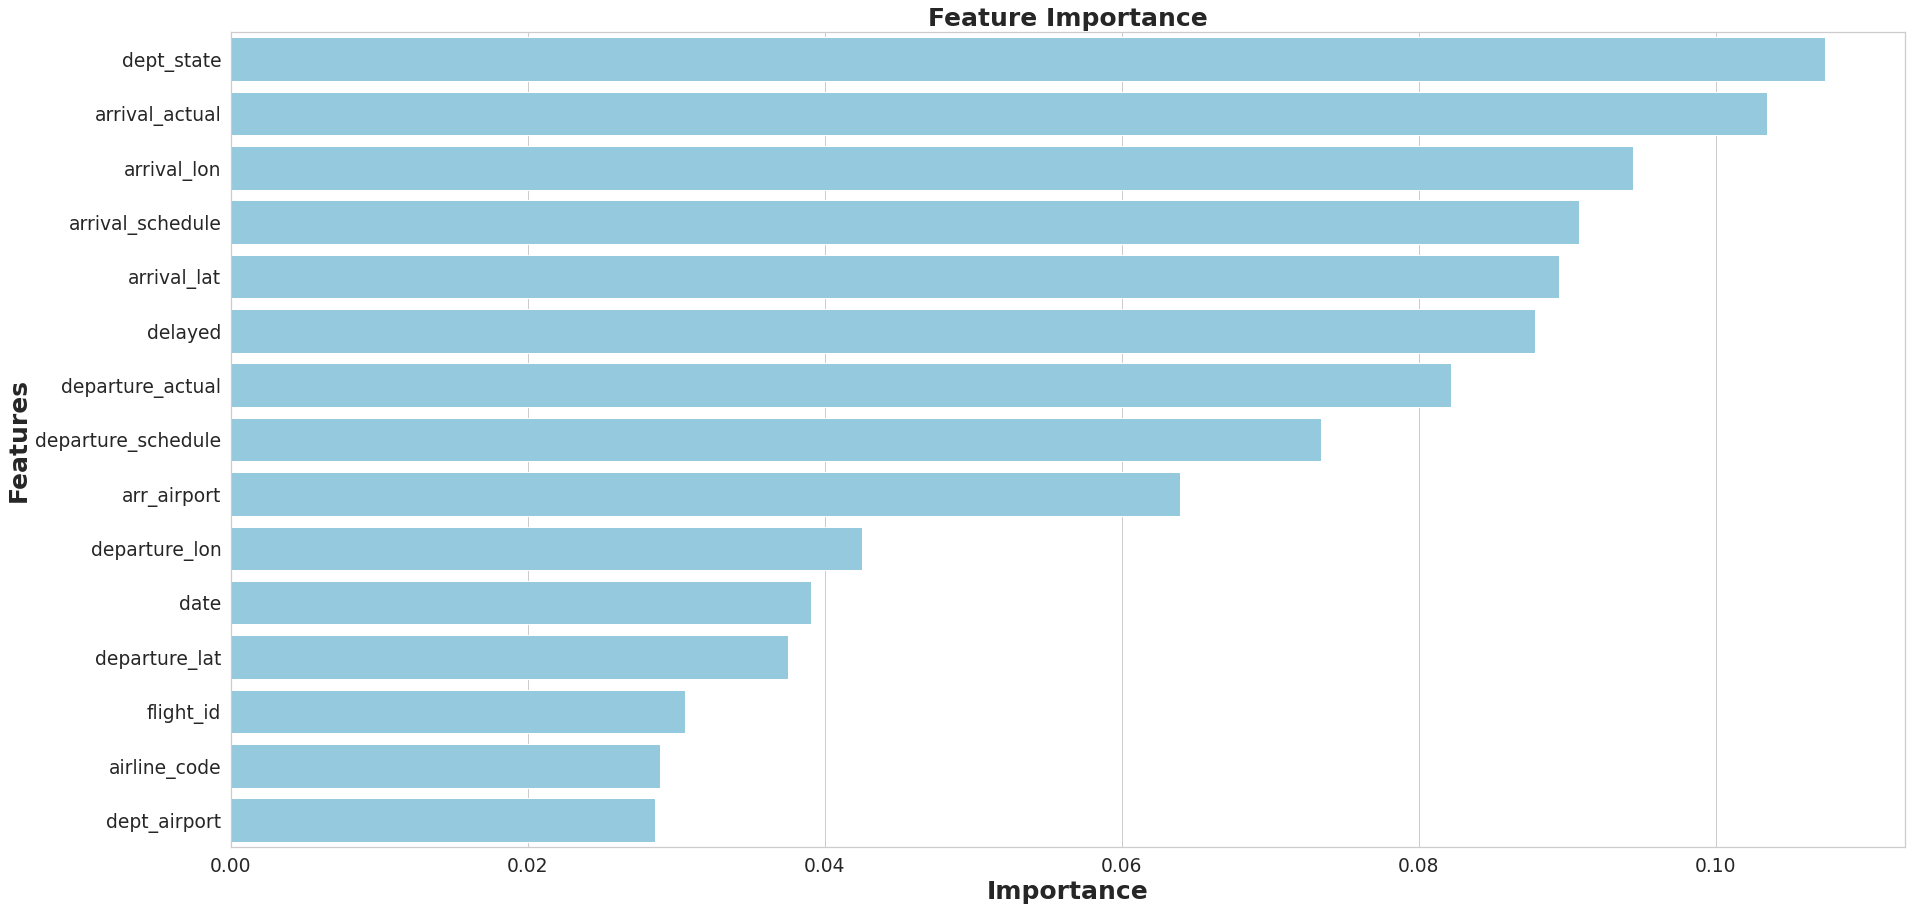

None

,Features,Gini-Importance
0,dept_state,0.107371
1,arrival_actual,0.103473
2,arrival_lon,0.094407
3,arrival_schedule,0.090799
4,arrival_lat,0.089463
5,delayed,0.087813
6,departure_actual,0.082146
7,departure_schedule,0.073422
8,arr_airport,0.063921
9,departure_lon,0.042495


In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

feats={}
for feature, importance in zip(data.columns, rfc.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})

sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

In [70]:
from datetime import datetime
startTimeGS = datetime.now()
from sklearn.model_selection import GridSearchCV

param_grid = {
                 'n_estimators': [10, 25],
#                 'min_samples_split': [2, 4],
#                 'min_samples_leaf': [2, 4],
#                 'max_features': ['sqrt', 'log2'],
                 "criterion" : ["gini", "entropy"]
             }
grid_rf = GridSearchCV(rfc, param_grid, cv=10)
grid_rf.fit(X_train, y_train)
bestModel = grid_rf.best_estimator_
bestParameters = grid_rf.best_params_
gridScores = grid_rf.best_score_
print('Random forest Grid Search took [', datetime.now() - startTimeGS, '] seconds.')

Random forest Grid Search took [ 0:01:01.188532 ] seconds.


In [37]:
print(bestModel)
print(bestParameters)
gridScores

RandomForestClassifier(criterion='entropy', n_estimators=25)
{'criterion': 'entropy', 'n_estimators': 25}


0.8877575876846823

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
startTimeRF = datetime.now()
rf = RandomForestClassifier(n_estimators = bestParameters.get('n_estimators'), 
#                            min_samples_split=bestParameters.get('min_samples_split'),
#                           min_samples_leaf = bestParameters.get('min_samples_leaf'),
#                           max_features = bestParameters.get('max_features'),
                           criterion = bestParameters.get('criterion'))
cv = KFold(len(X_train), shuffle=True, random_state=2)
cvScores = cross_val_score(rf, X_train, Y_train, cv=cv)
print ('Mean cross validation score is: ' + str(np.mean(cvScores)))
rf.fit(X_train, Y_train)
print('Random forest training and testing with with non-redundant variables took [', 
      datetime.now() - startTimeRF, '] seconds.')

